In [873]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


In [875]:
# Load dataset
clean_crop_yield_data = pd.read_csv("final_crop_yield_data.csv")
features = clean_crop_yield_data[['average_rain_fall_mm_per_year', 'avg_temp', 'pesticides_tonnes', 'yield']]


# Pre Clustering Exploratory Data Analysis (EDA)


In [878]:
# Preview each dataset

print("Preprocessed Clean Yield Data:")
print(clean_crop_yield_data.head(2))
print("\n",clean_crop_yield_data.describe())

Preprocessed Clean Yield Data:
      area   item  year  yield  average_rain_fall_mm_per_year  avg_temp  \
0  Albania  Maize  1990  36613                           1485     16.37   
1  Albania  Maize  1991  29068                           1485     15.36   

   pesticides_tonnes  
0              121.0  
1              121.0  

                year          yield  average_rain_fall_mm_per_year  \
count  13136.000000   13136.000000                   13136.000000   
mean    2001.617692   70959.634440                    1157.599269   
std        7.035556   79111.427638                     743.693891   
min     1990.000000      50.000000                      51.000000   
25%     1995.000000   18000.000000                     608.000000   
50%     2001.000000   39536.000000                    1083.000000   
75%     2008.000000   97159.000000                    1651.000000   
max     2013.000000  501412.000000                    3240.000000   

           avg_temp  pesticides_tonnes  
count  13

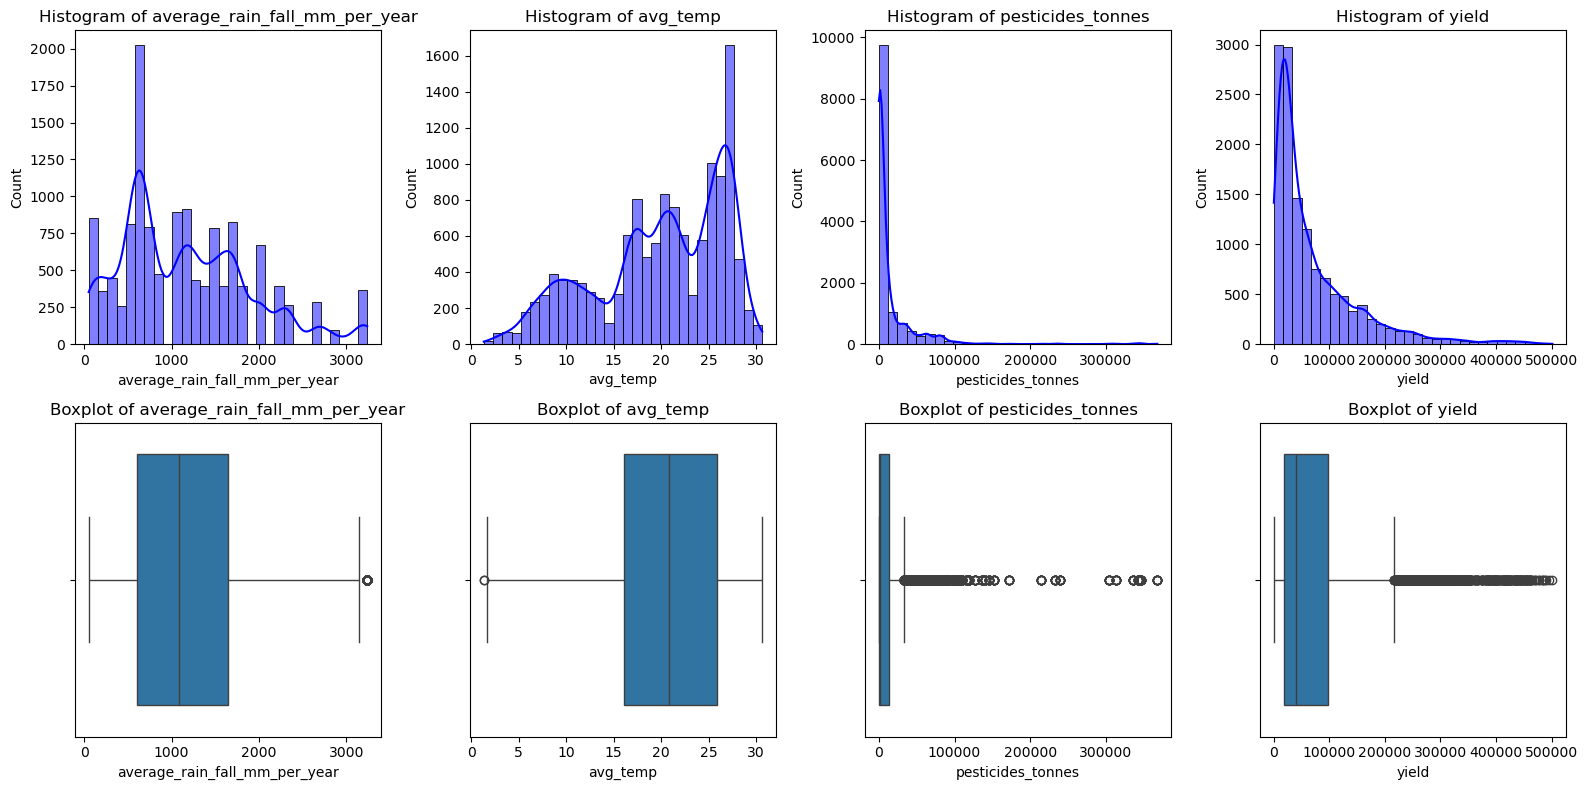

In [880]:
plt.figure(figsize=(16, 8))


for i, col in enumerate(features):
    plt.subplot(2, 4, i+1)
    sns.histplot(clean_crop_yield_data[col], kde=True, bins=30, color='blue')
    plt.title(f'Histogram of {col}')
    
    plt.subplot(2, 4, i+5)
    sns.boxplot(x=clean_crop_yield_data[col])
    plt.title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

In [881]:
total_crop_data = clean_crop_yield_data

# Correlation Heatmap
This shows relationships between variables.

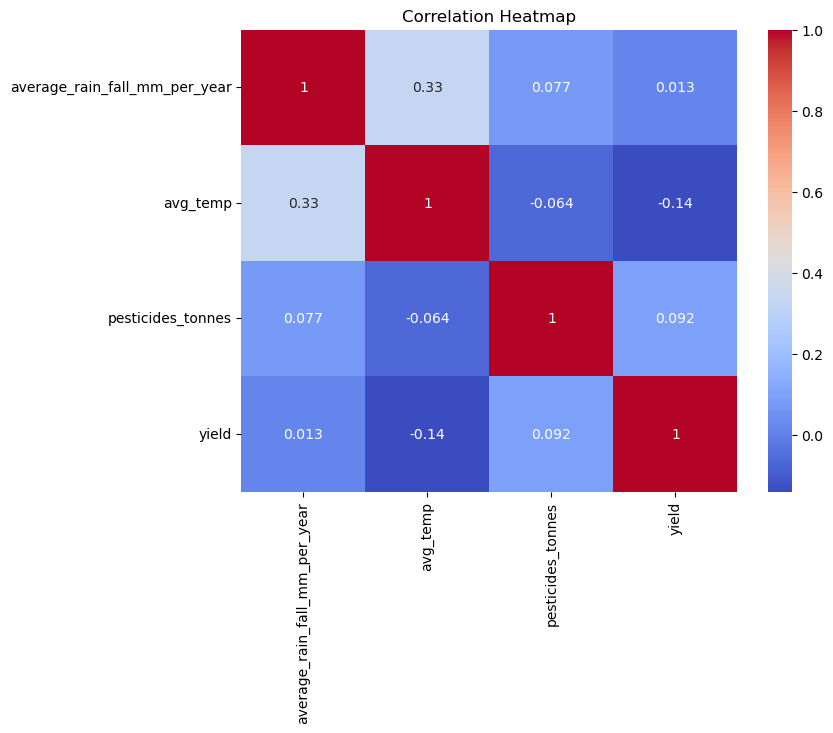

In [883]:
plt.figure(figsize=(8,6))
sns.heatmap(total_crop_data[features.columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Features are **weakly corelated**, The correlation matrix reveals that rainfall and normalized average temperature share the highest linear association (0.33), though the relationship is not strong enough to imply collinearity or redundancy

# PCA for Dimensionality Intuition
This helps us understand how many dimensions are needed to capture variance.

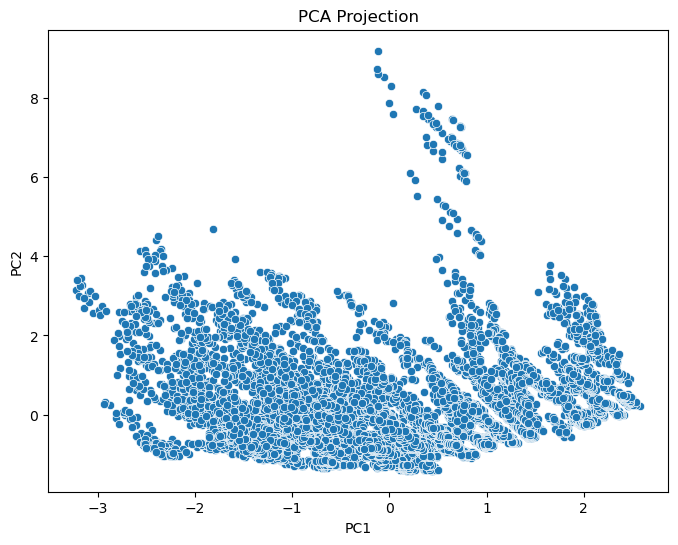

In [888]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(total_crop_data[features.columns])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

<Figure size 1000x600 with 0 Axes>

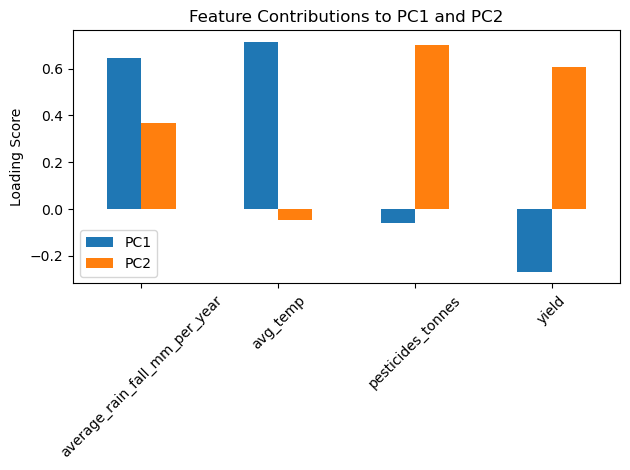

In [889]:

# Get PCA components (loadings)
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=features.columns)

# Plot loadings
plt.figure(figsize=(10,6))
loadings.plot(kind='bar')
plt.title("Feature Contributions to PC1 and PC2")
plt.ylabel("Loading Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PC1	**Rainfall, Temperature**	Climate and environmental conditions
PC2	**Pesticide, Yield**	Agricultural input and productivity
This means this dataset varies both by natural conditions and by human-driven farming practices. 

# Central Limit Theorem via Sampling Distributions
Let’s demonstrate CLT using sampling of yield.

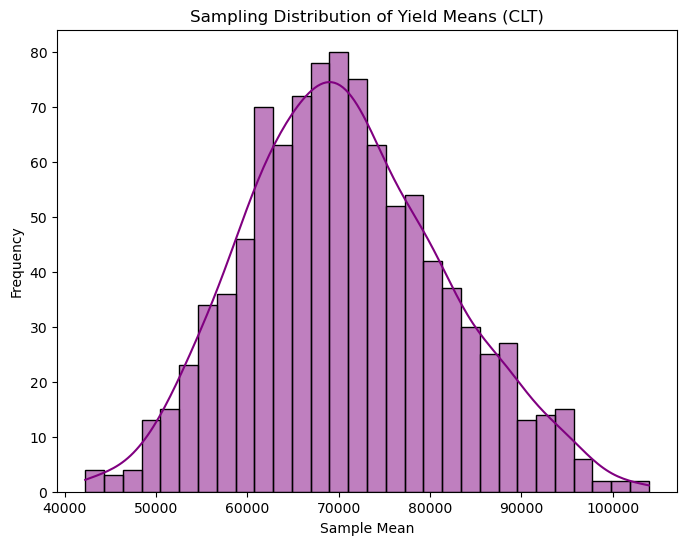

In [895]:
sample_means = []
for _ in range(1000):
    sample = total_crop_data['yield'].sample(n=50, replace=True)
    sample_means.append(sample.mean())

plt.figure(figsize=(8,6))
sns.histplot(sample_means, kde=True, bins=30, color='purple')
plt.title("Sampling Distribution of Yield Means (CLT)")
plt.xlabel("Sample Mean")
plt.ylabel("Frequency")
plt.show()

This confirms that statistical inference (e.g., confidence intervals, hypothesis testing) is valid on sample means.
Sampling-based techniques (like bootstrapping) using during rainfall missing data handling was a good idea, instead of dropping those rows.

# Clustering to Create a new feature - agro_zone

**K-Means clustering**

**Select Features for Clustering:**
               
average_rain_fall_mm_per_year

avg_temp

pesticides_tonnes

In [901]:
features_for_clustering = ['average_rain_fall_mm_per_year', 'avg_temp', 'pesticides_tonnes']
X = total_crop_data[features_for_clustering].copy()

**Scale the Features**

In [904]:
#Clustering is sensitive to scale, so I will standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Determine Optimal Number of Clusters**

Using the **Elbow Method** to find the best - k

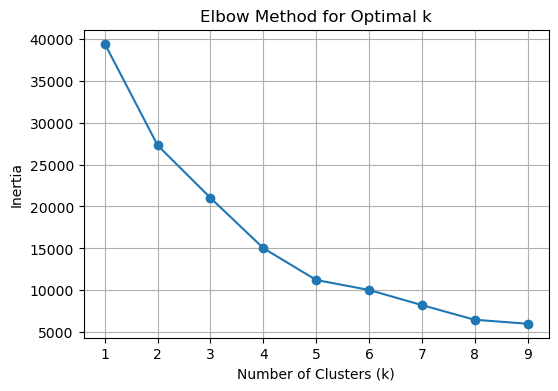

In [908]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

**Apply K-Means Clustering** looks like 5, can be 6

In [911]:
kmeans = KMeans(n_clusters=5, random_state=42)
total_crop_data['agro_zone'] = kmeans.fit_predict(X_scaled)
#created a new column agro_zone that captures latent environmental patterns.

**Visualize the Clusters**

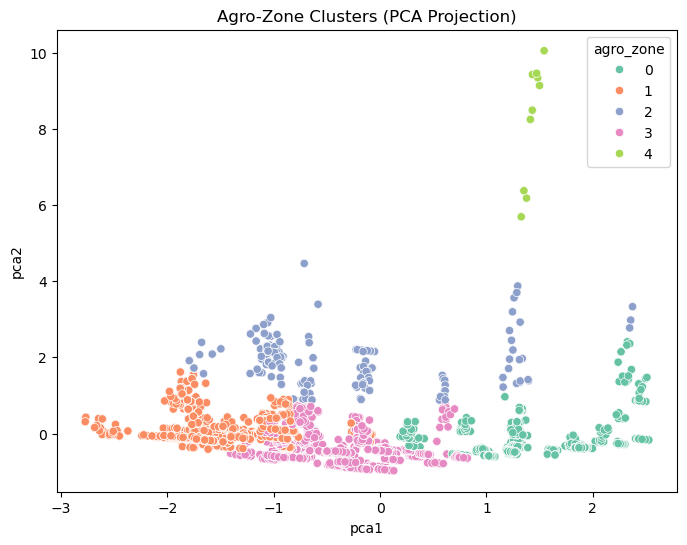

In [914]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

#yield_df['pca1'] = pca_result[:, 0]
#yield_df['pca2'] = pca_result[:, 1]

pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])
combined_df = pd.concat([total_crop_data, pca_df], axis=1)

plt.figure(figsize=(8,6))
sns.scatterplot(data = combined_df, x='pca1', y='pca2', hue='agro_zone', palette='Set2')
plt.title("Agro-Zone Clusters (PCA Projection)")
plt.show()

Created agro_zone feature using unsupervised learning

Captured hidden environmental structure

Ready to use this feature in the supervised regression pipeline

# Feature Engineering

Need to create features that reflect:

Efficiency (e.g., yield per pesticide)

Environmental ratios (e.g., rainfall vs. temperature)

Temporal trends (e.g., year grouping)


In [919]:
total_crop_data['agro_zone'].unique()

array([1, 3, 2, 0, 4])

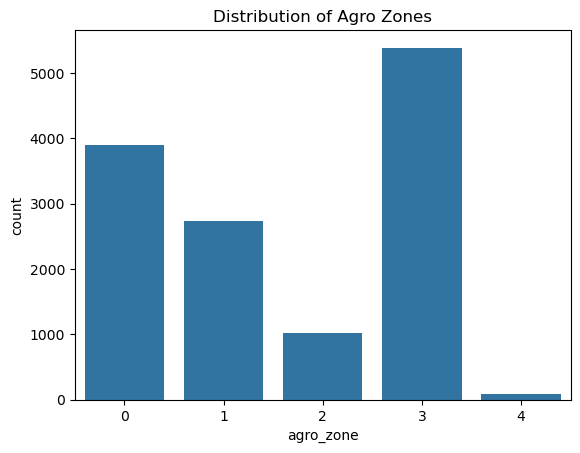

In [921]:
sns.countplot(x='agro_zone', data=total_crop_data)
plt.title('Distribution of Agro Zones')
plt.show()

In [923]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(total_crop_data[features.columns])
print(kmeans.cluster_centers_)

[[1.12837935e+03 2.00257830e+01 1.32744613e+04 3.03133508e+04]
 [1.02510701e+03 1.58487700e+01 2.70172077e+04 3.00478672e+05]
 [1.28205650e+03 2.04297865e+01 1.63259838e+04 1.33560781e+05]]


In [925]:
zone_summary = total_crop_data.groupby('agro_zone')[['average_rain_fall_mm_per_year', 'avg_temp', 'pesticides_tonnes']].mean()
print("zone_summary\n",zone_summary)

zone_summary
            average_rain_fall_mm_per_year   avg_temp  pesticides_tonnes
agro_zone                                                             
0                            2031.196713  24.876425        7105.468277
1                             850.102555   9.604584        8528.455467
2                            1126.546341  17.472790       78113.809766
3                             678.348431  21.810061        6751.669634
4                            1761.000000  25.631000      304005.000000


# Normalize the summary for visualization

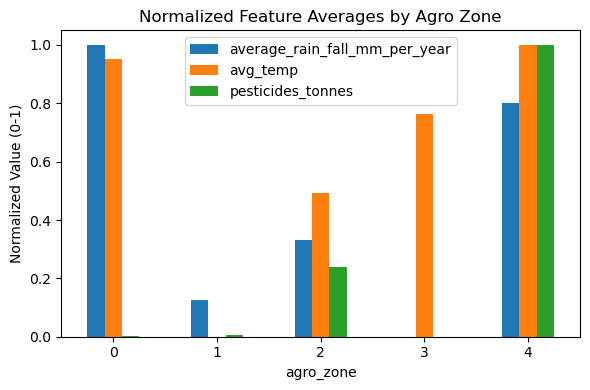

In [929]:

normalized_summary = zone_summary.copy()
normalized_summary = (normalized_summary - normalized_summary.min()) / (normalized_summary.max() - normalized_summary.min())

# Plot normalized values
normalized_summary.plot(kind='bar', figsize=(6,4))
plt.title("Normalized Feature Averages by Agro Zone")
plt.ylabel("Normalized Value (0-1)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Beautiful and meaningful impressive clusters**

**Zone 0**: Tropical, high rainfall and temperature, but surprisingly low pesticide use—possibly organic or low-input farming.

**Zone 1**: Cold and dry—likely unsuitable for most crops, or specialized low-input farming.

**Zone 2**: Balanced climate but high pesticide use—could be intensive farming with pest-prone crops.

**Zone 3**: Hot but dry—maybe arid farming with drought-resistant crops.

**Zone 4**: Extreme input zone—high everything, possibly industrial-scale farming with heavy chemical use.

# Feature Engineering

Yield Efficiency Features
1. Yield per Pesticide

In [933]:
#total_crop_data['item'].unique()
featured_yield_df = total_crop_data

**Yield Efficiency Features**

Yield per Pesticide

In [937]:
#Helps identify regions where pesticides are used efficiently vs. wastefully.
featured_yield_df['yield_per_pesticide'] = featured_yield_df['yield'] / (featured_yield_df['pesticides_tonnes'] + 1e-5)


**Environmental Ratios**
Rainfall-to-Temperature Ratio

In [940]:
#Captures how rainfall intensity relates to heat — useful for crop suitability.
featured_yield_df['rainfall_temp_ratio'] = featured_yield_df['average_rain_fall_mm_per_year'] / (featured_yield_df['avg_temp'] + 1e-5)

**Temporal Features**
Year Grouping

In [943]:
#Helps model shifts in agricultural practices or climate over time.
# Define bins and labels
bins = [1989, 1995, 2000, 2005, 2010, 2013]
labels = ['1990–95', '1996–2000', '2001–05', '2006–10', '2011–15']

# Create year groups
featured_yield_df['year_group'] = pd.cut(
    featured_yield_df['year'],
    bins=bins,
    labels=labels,
    right=False
)



# One-hot encoding

**One-Hot Encoding for Categorical Features**
Encode item, agro_zone and year_group for modeling:

In [947]:
# Step 1: Create dummy variables
year_group_dummies = pd.get_dummies(featured_yield_df['year_group'], prefix='year_group')
item_dummies = pd.get_dummies(featured_yield_df['item'], prefix='item')
agro_zone_dummies = pd.get_dummies(featured_yield_df['agro_zone'], prefix='agro_zone')

# Step 2: Drop original categorical columns
featured_yield_df.drop(columns=['year_group', 'item', 'agro_zone'], inplace=True)

# Step 3: Drop any duplicate columns (just in case)
featured_yield_df = featured_yield_df.loc[:, ~featured_yield_df.columns.duplicated()]

# Step 4: Merge dummy variables
featured_yield_df = pd.concat([featured_yield_df, year_group_dummies, item_dummies, agro_zone_dummies], axis=1)

In [949]:
print(featured_yield_df.head(2))
print(featured_yield_df.columns)

      area  year  yield  average_rain_fall_mm_per_year  avg_temp  \
0  Albania  1990  36613                           1485     16.37   
1  Albania  1991  29068                           1485     15.36   

   pesticides_tonnes  yield_per_pesticide  rainfall_temp_ratio  \
0              121.0           302.586752            90.714667   
1              121.0           240.231385            96.679625   

   year_group_1990–95  year_group_1996–2000  ...  item_Sorghum  item_Soybeans  \
0                True                 False  ...         False          False   
1                True                 False  ...         False          False   

   item_Sweet potatoes  item_Wheat  item_Yams  agro_zone_0  agro_zone_1  \
0                False       False      False        False         True   
1                False       False      False        False         True   

   agro_zone_2  agro_zone_3  agro_zone_4  
0        False        False        False  
1        False        False        False

### Feature Type	Columns Included

Environmental - average_rain_fall_mm_per_year, avg_temp, pesticides_tonnes, rainfall_temp_ratio, yield_per_pesticide

Temporal - year_group_1990–95 to year_group_2011–15

Crop Type - item_Maize, item_Potatoes, etc.

Agro Zones  - agro_zone_0 to agro_zone_4

Metadata - area, year, yield — useful for tracking or post-analysis

# EDA Pre supervised learnig Regression model and Post Clustering

**Feature Distribution by Cluster**

In [955]:

print(featured_yield_df.shape)
print(featured_yield_df.dtypes)
print(featured_yield_df.isnull().sum())

(13136, 28)
area                              object
year                               int64
yield                              int64
average_rain_fall_mm_per_year      int64
avg_temp                         float64
pesticides_tonnes                float64
yield_per_pesticide              float64
rainfall_temp_ratio              float64
year_group_1990–95                  bool
year_group_1996–2000                bool
year_group_2001–05                  bool
year_group_2006–10                  bool
year_group_2011–15                  bool
item_Cassava                        bool
item_Maize                          bool
item_Plantains and others           bool
item_Potatoes                       bool
item_Rice, paddy                    bool
item_Sorghum                        bool
item_Soybeans                       bool
item_Sweet potatoes                 bool
item_Wheat                          bool
item_Yams                           bool
agro_zone_0                         bool
agro

Shape
13,136 rows, 26 columns — good sample size for regression.

Missing Values - 
Zero nulls, across all columns — Because of my Data Preprocessing using bootstrapping.

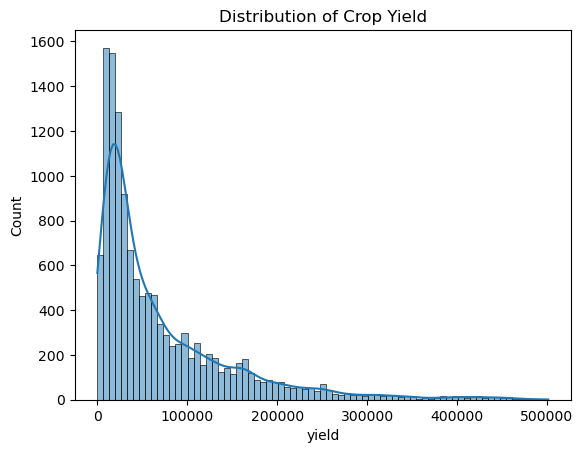

In [958]:
sns.histplot(featured_yield_df['yield'], kde=True)
plt.title('Distribution of Crop Yield')
plt.show()

### L-Shaped Distribution Means
Most values are clustered near zero, with a long tail of large values, towards right.

This indicates positive skewness — a few extremely high-yield records are stretching the distribution.

**Bias toward the majority**: Models will focus on predicting the dense low-yield region and ignore the high-yield outliers.

**Poor error metrics**: RMSE or MAE will be dominated by errors in the tail.

**Heteroscedasticity**: Variance of errors increases with yield, violating assumptions of many models.

**Apply Log Transformation** - fix for skewed targets:

In [962]:

# Create a log-transformed target
featured_yield_df['log_yield'] = np.log1p(featured_yield_df['yield'])

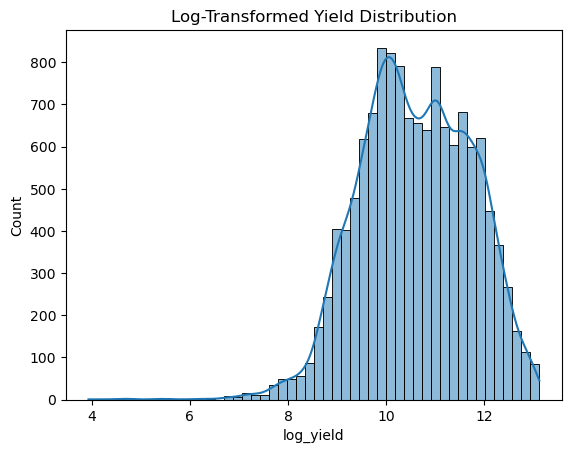

In [964]:
#Visualize the Fix
sns.histplot(featured_yield_df['log_yield'], bins=50, kde=True)
plt.title("Log-Transformed Yield Distribution")
plt.show()

### more symmetric, bell-shaped curve — ideal for regression

Convert Boolean Columns for Modeling

In [968]:
featured_yield_df = featured_yield_df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
#predicted_yield = np.expm1(model.predict(X_test)) for the reverse to get predicted data

### Correlation Heatmap

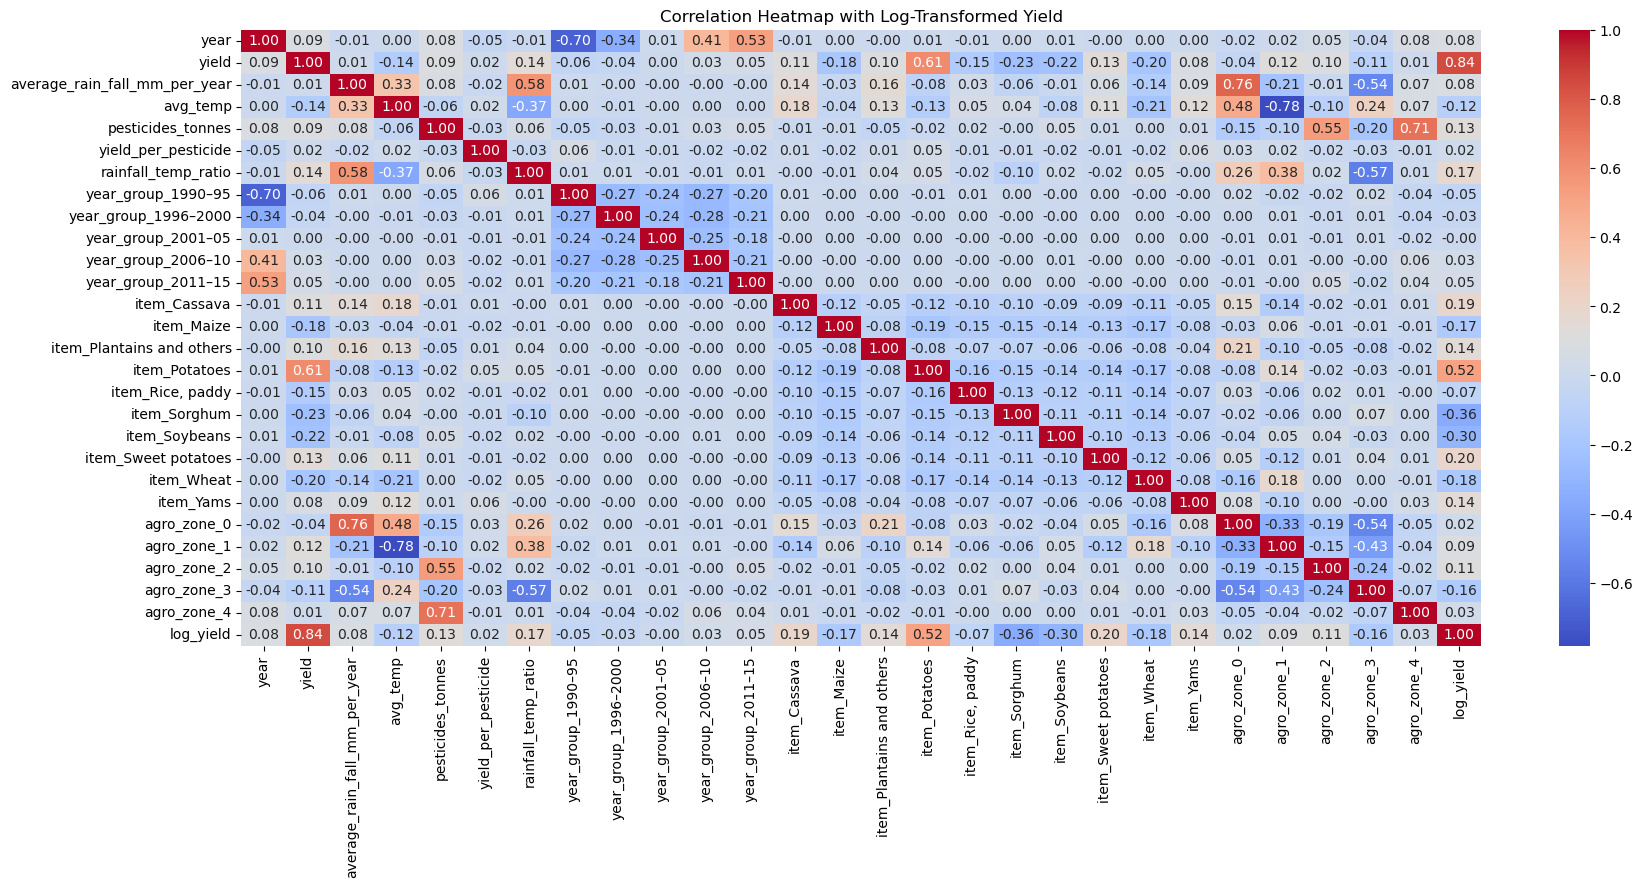

In [971]:
# Select only numeric columns
numeric_df = featured_yield_df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Log-Transformed Yield")
plt.show()

# Model building

In [973]:
from sklearn.model_selection import train_test_split

# Define features and target
# Drop raw yield and log_yield and area as I have created my agro_zones to evaluate the model on the basis of environmental zones 

X = featured_yield_df.drop(columns=['yield', 'log_yield', 'area']) 
y = featured_yield_df['log_yield']             # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [974]:
#from sklearn.linear_model import LinearRegression - initially though of linear then picked ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ridge pipeline with scaling
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Update models dictionary
models = {
    'Ridge Regression': ridge_pipeline,
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [975]:
# Evaluation

In [982]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_test)

    print(f"\n{name}")
    print(f"R²: {r2_score(y_true, y_pred):.3f}")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")

for name, model in models.items():
    evaluate_model(name, model)


Ridge Regression
R²: 0.581
RMSE: 51123.898
MAE: 29812.796

Random Forest
R²: 0.978
RMSE: 11710.186
MAE: 5323.454

Gradient Boosting
R²: 0.846
RMSE: 30994.462
MAE: 15446.296


# Cross Validation

In [985]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    print(f"\n{name} - CV R²: {scores.mean():.3f} ± {scores.std():.3f}")


Ridge Regression - CV R²: 0.659 ± 0.011

Random Forest - CV R²: 0.983 ± 0.001

Gradient Boosting - CV R²: 0.934 ± 0.002


# Bias–Variance Tradeoff & Learning Curves

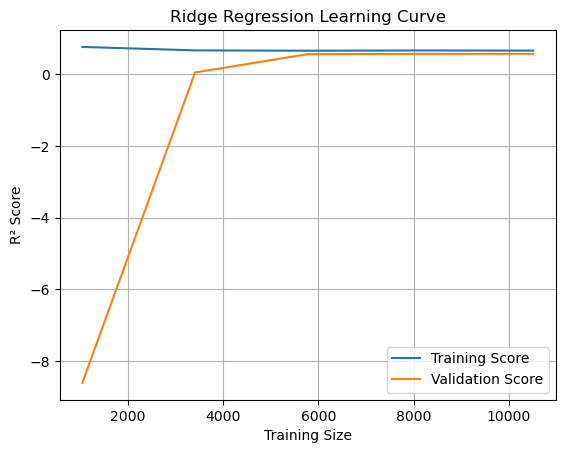

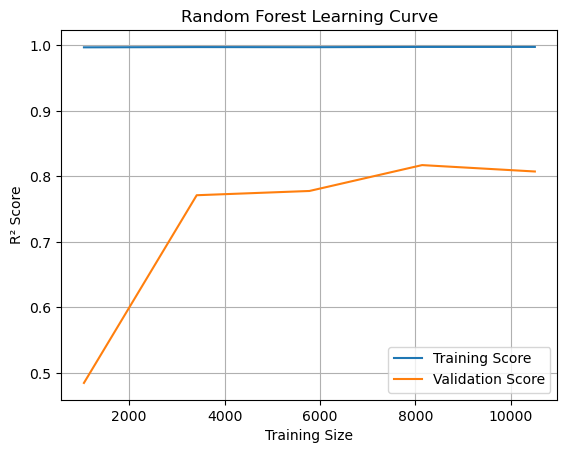

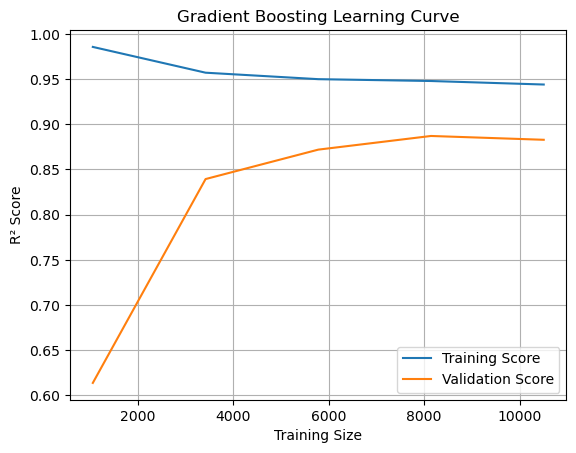

In [988]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label='Training Score')
    plt.plot(train_sizes, test_mean, label='Validation Score')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)
    plt.show()

for name, model in models.items():
    plot_learning_curve(model, f"{name} Learning Curve")

### The GB is more promising in the path of Learning, it beats RF in this case, otherwise RF was winner so far with accuracy.

### Optuna - It uses a Bayesian-inspired approach for Hyper parameter Tuning

In [1011]:
!pip install optuna
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
    }

    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_test)
    
    return r2_score(y_true, y_pred)

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print the best parameters
print("Best trial:")
trial = study.best_trial
print(f"R² Score: {trial.value:.4f}")
print("Best hyperparameters:", trial.params)

[I 2025-08-06 14:32:17,861] A new study created in memory with name: no-name-d95f5eb4-44ab-40e1-80db-03c3f8a9e701


[I 2025-08-06 14:32:27,454] Trial 0 finished with value: 0.9857725271144413 and parameters: {'n_estimators': 260, 'learning_rate': 0.27368702677698387, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.7838912273772639}. Best is trial 0 with value: 0.9857725271144413.
[I 2025-08-06 14:32:42,999] Trial 1 finished with value: 0.9881034824667823 and parameters: {'n_estimators': 351, 'learning_rate': 0.1962868001805441, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.675235470310776}. Best is trial 1 with value: 0.9881034824667823.
[I 2025-08-06 14:32:55,335] Trial 2 finished with value: 0.9852478999081129 and parameters: {'n_estimators': 249, 'learning_rate': 0.2521836116039103, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.8660701990709674}. Best is trial 1 with value: 0.9881034824667823.
[I 2025-08-06 14:33:08,997] Trial 3 finished with value: 0.9820653000294586 and parameters: {'n_estimators': 364

Best trial:
R² Score: 0.9886
Best hyperparameters: {'n_estimators': 399, 'learning_rate': 0.11540776094774523, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5, 'subsample': 0.8460849802190643}


In [1013]:
# Extract best parameters
best_params = study.best_trial.params

# Rebuild and train the best model
best_gb_model = GradientBoostingRegressor(**best_params)
best_gb_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.11540776094774523, max_depth=7,
                          min_samples_leaf=5, min_samples_split=4,
                          n_estimators=399, subsample=0.8460849802190643)

Best trial:
R² Score: 0.9890
Best hyperparameters: {'n_estimators': 400, 'learning_rate': 0.16142959165396592, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.8462023505074792}

In [ ]:
# SHAP For Feature Interpretability

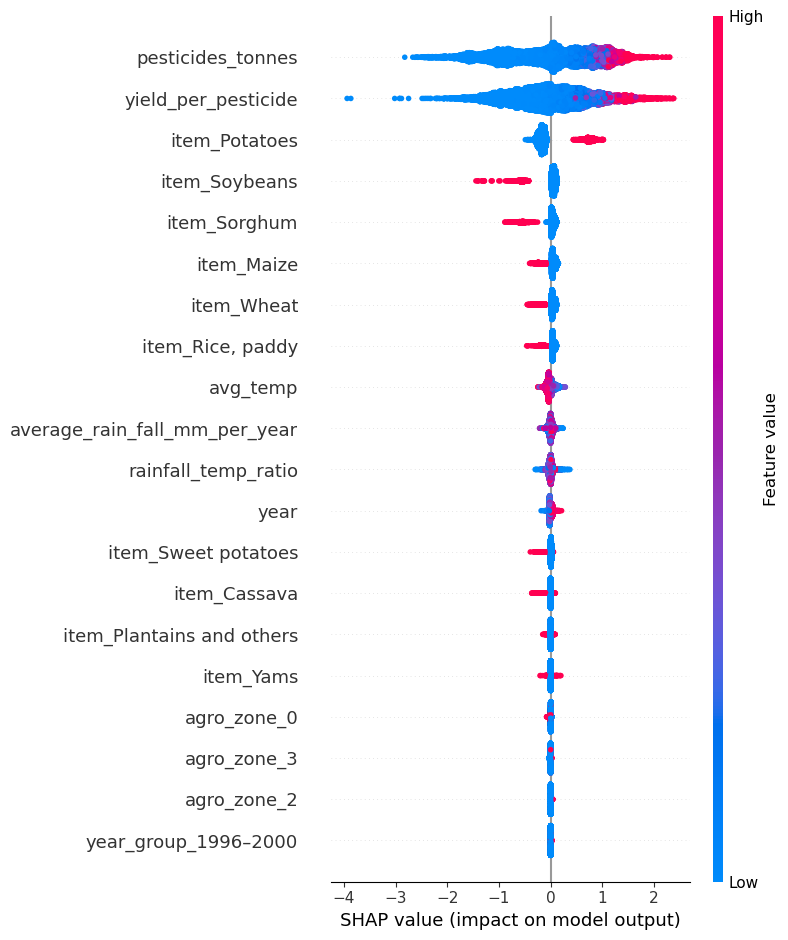

In [1017]:
!pip install shap

import shap
import matplotlib.pyplot as plt

# Using the trained Gradient Boosting model from Optuna optimizer trial
# For SHAP compatibility, lets wrap with TreeExplainer
explainer = shap.Explainer(best_gb_model)

# SHAP values for your dataset (X)
shap_values = explainer(X)

# Summary plot of feature importance
shap.summary_plot(shap_values, X)

# Optional: force plot for individual prediction
shap.plots.force(shap_values[0])

 99%|===================| 2610/2628 [01:10<00:00]        

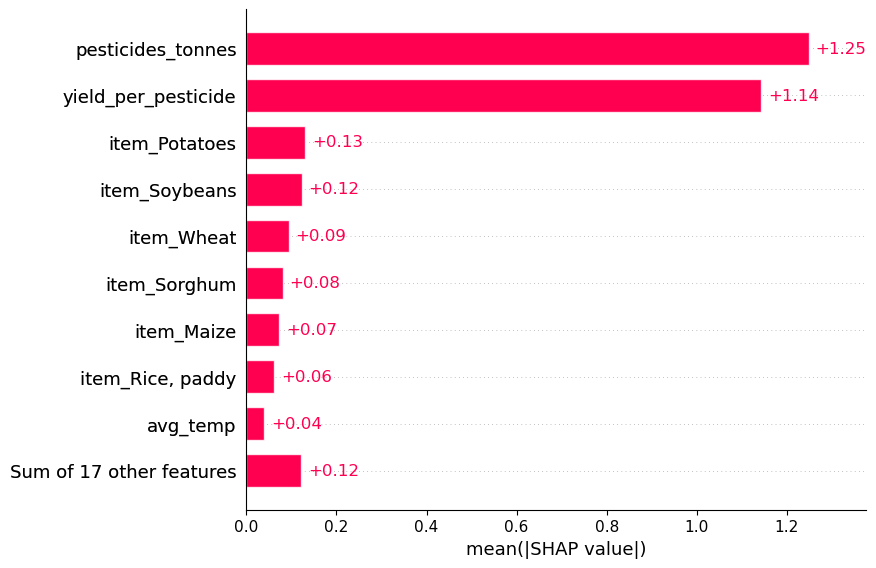

In [1019]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_gb_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot feature importance as bars
shap.plots.bar(shap_values)

Through SHAP analysis, we exposed how different inputs affect yield—offering a pathway toward smarter resource allocation and agro-policy decisions.
Notably, pesticide usage and high-yield crops like potato emerged as dominant factors.

# Thank You!